<h1><center>Mineração Estatística de Dados</center></h1>
<h2><center>Projeto 2: Classificação: Árvores de decisão e redes neurais</center></h2>
<br>
<br>
<br>


<h2><center>Bruno Gomes Coelho - 9791160</center></h2>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Imports e ler os dados

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split


N_SAMPLES = 1000
N_SIMUL = 50
TESTING = False

if TESTING:
    N_SAMPLES = 10
    N_SIMUL = 2

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q1

**Considere os dados gerados com a função:** `skdata.make_moons(n_samples=n_samples, noise=p)`.

**Construa um gráfico da acurácia versus a taxa de ruído para os algoritmos random  forest  e  redes  neurais.  Considerem  uma  média  de  ao  menos  10 simulações.**

In [2]:
def run_models(x, y, processing="Nada", testing=False, val_idx=None, train_idx=None,
               names=["RF", "MLP"],
               models=[RandomForestClassifier(), MLPClassifier()], 
               result_cols=["Score", "Model", "Pré-Processamento"]):
    """Helper function for quickly evaluating RF and Neural networks"""
    
    model_results = []
    all_results = pd.DataFrame(columns=result_cols)

    for model, name in zip(models, names):
        scaler = StandardScaler()
        scaled_x = scaler.fit_transform(x)
        if val_idx is not None:
            scaled_x = pd.DataFrame(scaled_x, columns=x.columns)
            if train_idx is not None:
                model.fit(scaled_x.iloc[train_idx], y.iloc[train_idx])
                mean_score = accuracy_score(y.iloc[val_idx], 
                                            model.predict(scaled_x.iloc[val_idx]))
            else:
                model.fit(scaled_x[~val_idx], y[~val_idx])
                mean_score = accuracy_score(y[val_idx], 
                                            model.predict(scaled_x[val_idx]))
        # Neither a val nor train index was passed;
        # We shall use 5 fold cross validation
        else:
            mean_score = cross_val_score(model, scaled_x, y, scoring="accuracy", 
                                     cv=5, n_jobs=-1).mean()
        model_results.append(mean_score)
        all_results.loc[len(all_results)] = [mean_score, name, processing]
    return all_results

In [3]:
%%capture
%%time
noises = [x/10 for x in range(10)]
df_cols = ["Score", "Model", "Ruido %"]
all_results = pd.DataFrame(columns=df_cols)

for noise in noises:
    for _ in range(N_SIMUL):
        x, y = make_moons(n_samples=N_SAMPLES, noise=noise)
        all_results = all_results.append(run_models(x, y, processing=f"{100*noise}%",
                                                    result_cols=df_cols),
                                         ignore_index=True, sort=False)

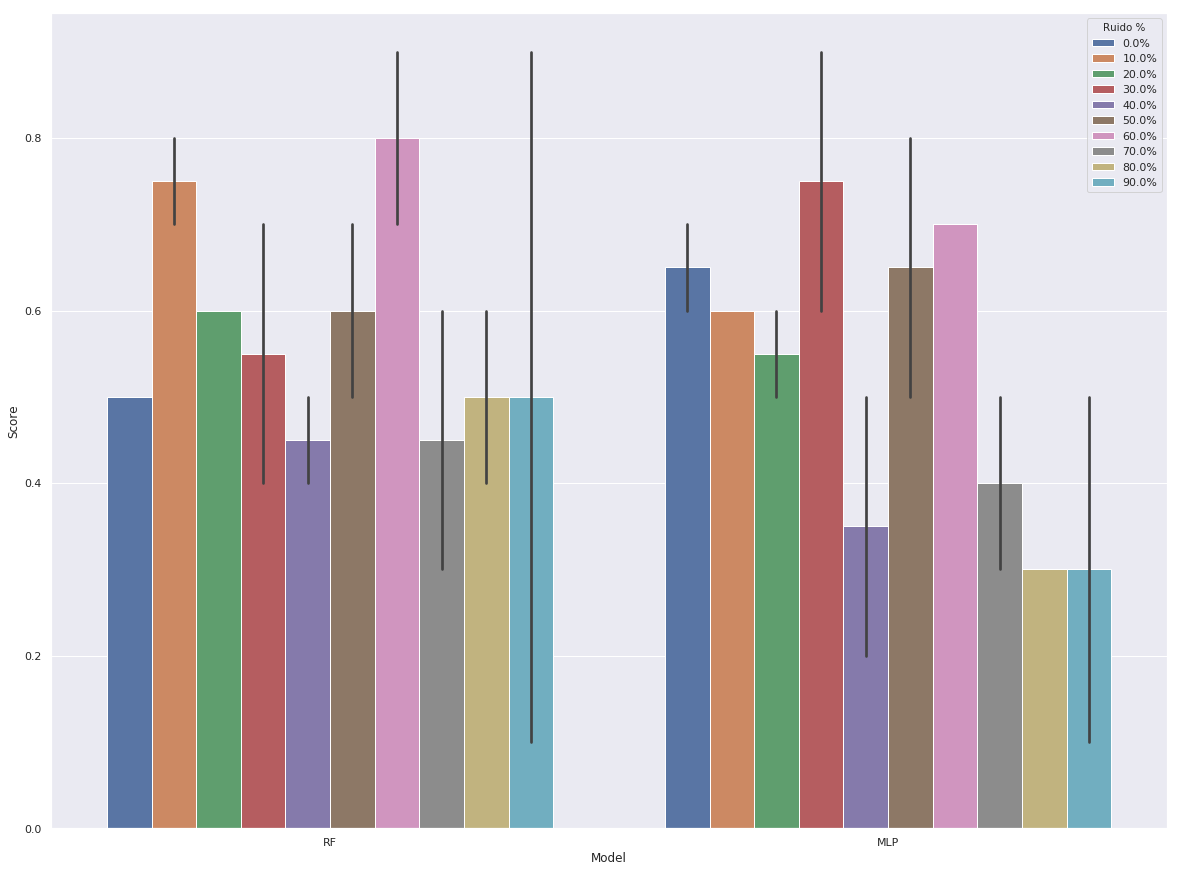

In [4]:
plt.figure(figsize=(20, 15))
sns.barplot(data=all_results, y="Score", x="Model", hue="Ruido %")



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q2

**No caso do algoritmo random forest, faça um gráfico da acurácia em função do número de árvores para a base Vehicle. Considere uma média de ao menos 10 simulações.**

In [5]:
FILE = "data/Vehicle.csv"
df = pd.read_csv(FILE)
print(f"Quantidade de nulos: ", df.isna().sum().sum())
print(df.shape)
df.head()

Quantidade de nulos:  0
(846, 19)


,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


## Vamos escalar os dados devido a MLP

In [6]:
scaler = StandardScaler()
std_df = scaler.fit_transform(df.drop(columns=["Class"]))

In [7]:
param_grid = {
    "n_estimators": [x for x in range(1, 300, 10)]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, 
                           scoring="accuracy", n_jobs=-1, cv=5, verbose=1, 
                           return_train_score=False)

In [8]:
%%time
grid_search.fit(std_df, df["Class"])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 263 ms, sys: 36 ms, total: 299 ms
Wall time: 12.6 s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=1)

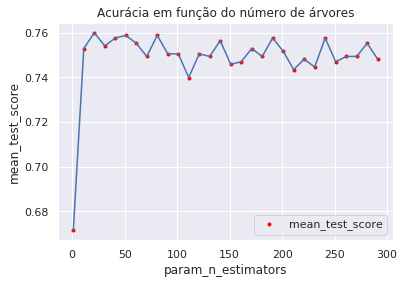

In [9]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values("rank_test_score", inplace=True)

plt.plot(results["param_n_estimators"], results["mean_test_score"], ".", color="red")
sns.lineplot(x="param_n_estimators", y="mean_test_score", data=results)
plt.title("Acurácia em função do número de árvores");

In [10]:
print(f"Melhor Acurácia: {grid_search.best_score_}\n", 
      f"Melhor parâmetro: {grid_search.best_params_}")

Melhor Acurácia: 0.7600472813238771
 Melhor parâmetro: {'n_estimators': 21}




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q3

**Verifique a influencia do número de camadas da rede neural na classificação para a base Vehicle. Considere o exemplo mostrado na aula.**

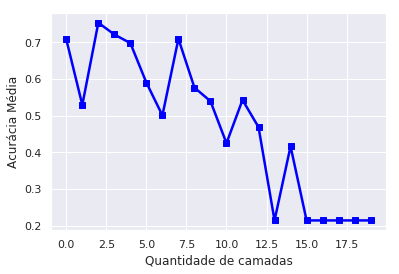

In [11]:
num_neurons = 10
all_scores = []
all_layers = []
num_layers = range(20) 
layers = (num_neurons,) # we'll have to append to this tupple each interaction

for nl in num_layers:
    layers = layers + (num_neurons,) # increase the number of layers
    all_layers.append(layers)
    accuracy = []
    
    for s in range(N_SIMUL): # average over Ns simulations
        train_x, test_x, train_y, test_y = train_test_split(df.drop(columns="Class"), 
                                                            df["Class"], 
                                                            test_size = 0.7,
                                                           random_state=42)
        scaler = MinMaxScaler()  
        scaler.fit(train_x)  
        train_x = scaler.transform(train_x)  
        test_x = scaler.transform(test_x)  
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=layers, random_state=42)
        clf.fit(train_x, train_y)
        pred_y = clf.predict(test_x)
        accuracy.append(accuracy_score(pred_y, test_y))
    all_scores .append(np.mean(accuracy))

plt.plot(num_layers, all_scores, marker='s', linestyle='-', color="blue", linewidth=2.5)
plt.xlabel("Quantidade de camadas")
plt.ylabel("Acurácia Média")
plt.grid(True)
plt.show(True)




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q4
**Analise outras função que definem o parâmetro solver da rede neural e compare os resultados para a base Vehicle. Isto, considere os casos: `solver= {‘lbfgs’,  ‘sgd’,  ‘adam’}`.  Considere  a  rede  neural  com  a  melhor  configuração (número de camadas) no exercício anterior.**

<br>
<br>
<br>


Vamos primeiros ver qual a melhor configuração das camadas:

In [12]:
best_layer_amount = all_layers[np.argmax(all_scores)]
print(f"Melhor configuração de camadas: {best_layer_amount}")

Melhor configuração de camadas: (10, 10, 10, 10)


In [13]:
solvers = ["lbfgs", "sgd", "adam"]

In [14]:

df_cols = ["Score", "Model", "Solver"]
all_results = pd.DataFrame(columns=df_cols)

for solver in solvers:
    for _ in range(N_SIMUL):
        all_results = all_results.append(run_models(df.drop(columns="Class"), 
                                                    df["Class"], 
                                                    names=["MLP"],
                                                    models=[MLPClassifier(solver=solver)],
                                                    processing=solver, 
                                                    result_cols=df_cols),
                                            ignore_index=True)
        

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

In [15]:
all_results

,Score,Model,Solver
0,0.841456,MLP,lbfgs
1,0.841456,MLP,lbfgs
2,0.724725,MLP,sgd
3,0.724725,MLP,sgd
4,0.826279,MLP,adam
5,0.826279,MLP,adam


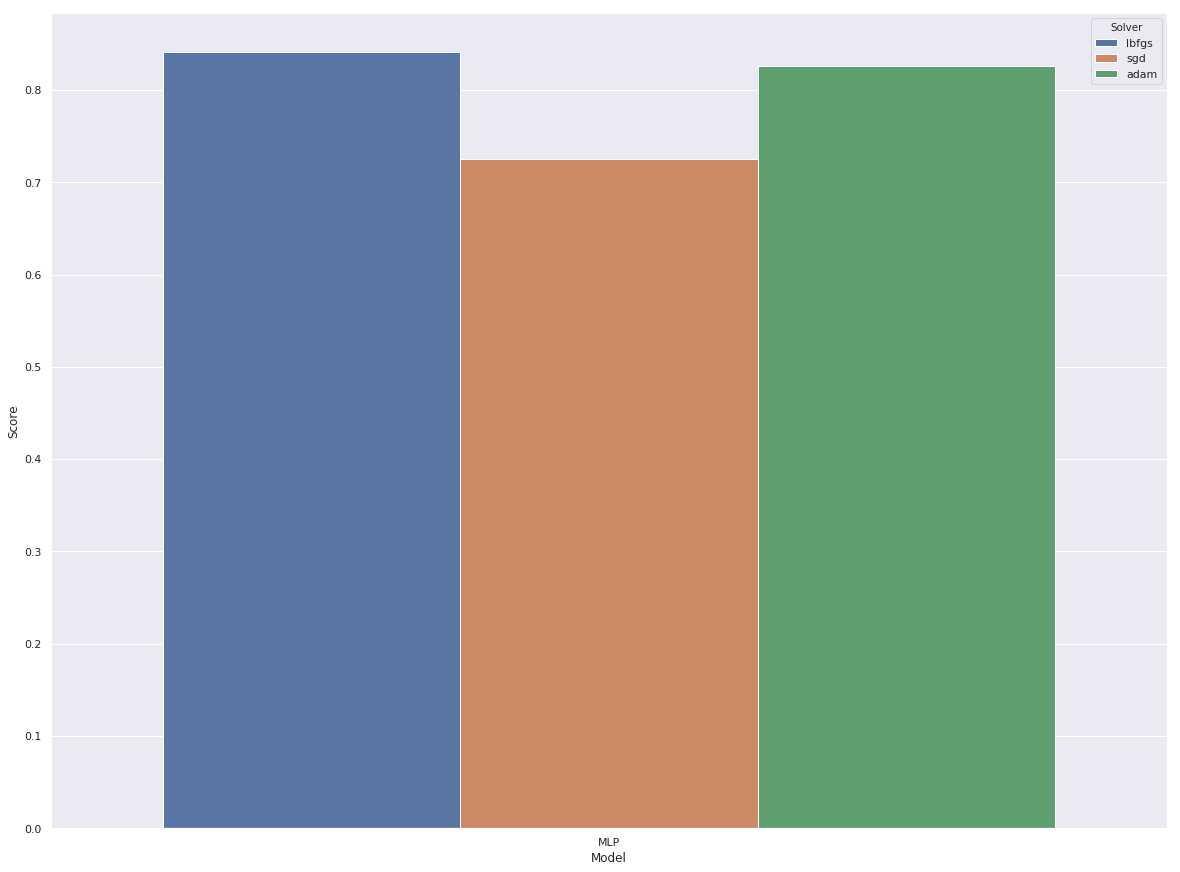

In [16]:
plt.figure(figsize=(20, 15))
sns.barplot(data=all_results, y="Score", x="Model", hue="Solver")



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q5

**Verifique  a  influência  do  tamanho  do  conjunto  de  treinamento  nos classificadores random forest e neural networks. Essa análise é semelhante à realizada no projeto 1.**

In [17]:
%%time
df_cols = ["Score", "Model", "% do treino"]
all_results = pd.DataFrame(columns=df_cols)
val_idx = np.random.choice([False, True], size=len(df), p=[0.7, 0.3])

fractions = [x/10 for x in range(1, 11)]
scores = []
for frac in fractions:
    train_idx = pd.DataFrame(df[val_idx]).sample(frac=frac).index
    all_results = all_results.append(run_models(df.drop(columns="Class"), df["Class"], 
                                                processing=str(100*frac), 
                                                result_cols=df_cols,
                                                val_idx=val_idx, train_idx=train_idx),
                                     ignore_index=True)


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

CPU times: user 7.25 s, sys: 10.8 s, total: 18.1 s
Wall time: 3.22 s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


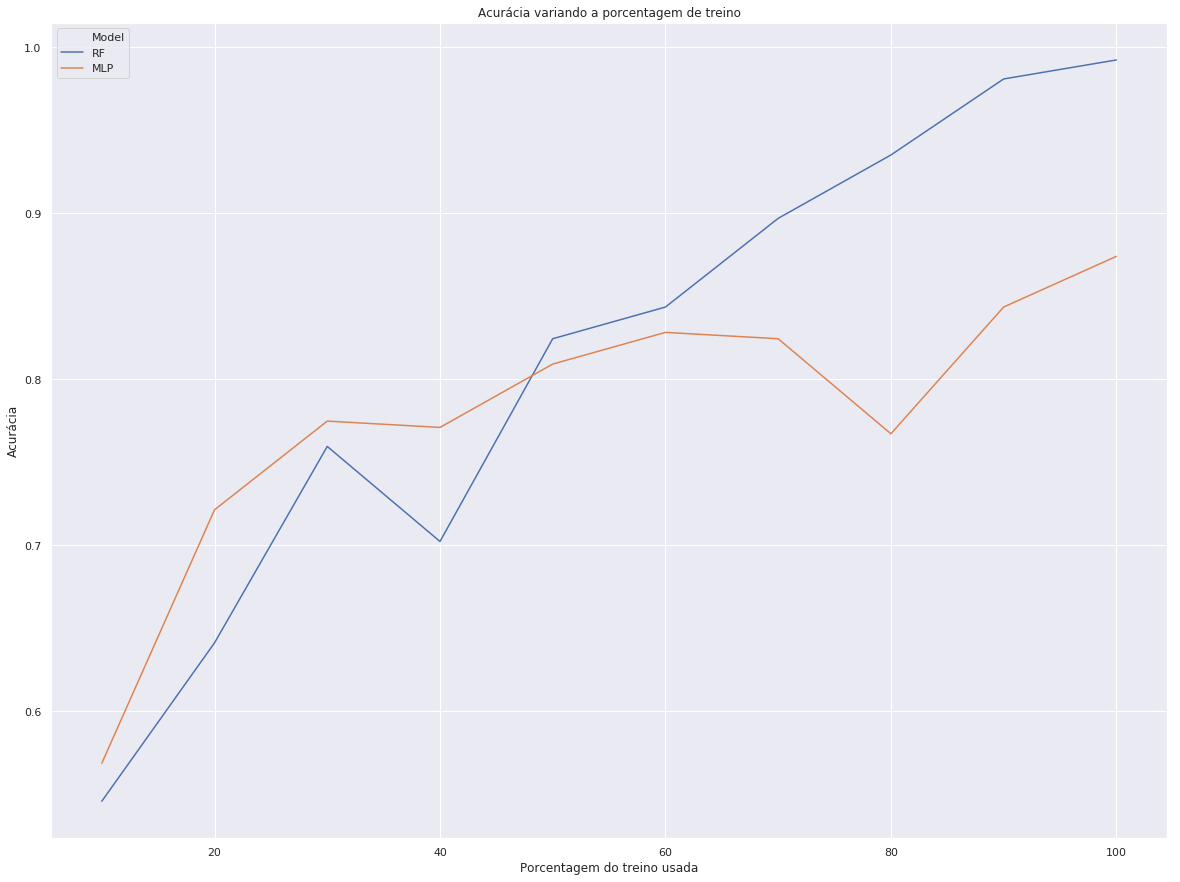

In [18]:
plt.figure(figsize=(20, 15))
all_results["% do treino"] = all_results["% do treino"].astype(float)
sns.lineplot(data=all_results, y="Score", x="% do treino", hue="Model")
plt.title("Acurácia variando a porcentagem de treino")
plt.xlabel("Porcentagem do treino usada");
plt.ylabel("Acurácia");